In [1]:
%reset
# !module load texlive
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import matplotlib
%matplotlib inline

import pickle as pk
import numpy as np
import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')
import torch

dev = torch.device("cuda")
# torch.cuda.set_device(dev)
import torch.optim as optim
from torch.distributions import MultivariateNormal
from torch.distributions import Normal
# change the root directory for this notebook

root_dir = '/mnt/home/spandey/ceph/AR_NPE/'
os.chdir(root_dir)
import colossus
import sys, os
from nf.combined_models import COMBINED_Model
from nf.all_models import *
from nf.utils_data_prep import *
from tqdm import tqdm
%load_ext autoreload
%autoreload 2




In [2]:
import colossus
# set cosmology
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
# get halo mass function:
from colossus.lss import mass_function
Mmin=13.1
Mmax=16.0
lgM_array = np.linspace(Mmin, Mmax, 1000)
M_array = 10**lgM_array
# hmf_tinker = mass_function.massFunction(M_array, 0, mdef = '200c', model = 'tinker08', q_out = 'dndlnM')
# hmf_sheth99 = mass_function.massFunction(M_array, 0, mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
hmf_bh11 = mass_function.massFunction(M_array, 0, mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
lgM_rescaled = (lgM_array - Mmin)/(Mmax-Mmin) -0.5

int_val = sp.integrate.simps(hmf_bh11, lgM_rescaled)
hmf_bh11_pdf = hmf_bh11/int_val
# define the cdf of the halo mass function
hmf_bh11_cdf = np.zeros_like(hmf_bh11_pdf)
for i in range(len(hmf_bh11_cdf)):
    hmf_bh11_cdf[i] = sp.integrate.simps(hmf_bh11_pdf[:i+1], lgM_rescaled[:i+1])

    


In [3]:
ji = 0
ns_d = 128
# ns_d = 256
# ns_d = 512
nb = 8
nax_d = ns_d // nb
nf = 3
layers_types = ['res', 'res', 'res', 'res']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

# z=127 is the initial condition
z_all = [0, 127, 'z_0_diff_sig_1', 'z_0_diff_sig_3']
# z_all_FP = [0, 99, 'z_0_diff_sig_1', 'z_0_diff_sig_3', 'M0_cond', 'M1_cond']
z_all_FP = [0, 99, 'z_0_diff_sig_1', 'M0_cond', 'M1_cond']
# z_all = [0]
# ns_h = 128
ns_h = 128
nax_h = ns_h // nb

nsims_per_batch = 32
# nbatches_train = nb**3//nsims_per_batch
nbatches_train = 16






In [4]:
hidden_dim_MAF = 5
learning_rate = 0.01
K_M1 = 5
B_M1 = 0.5
nflows_M1_NSF = 5

K_Mdiff = 5
B_Mdiff = 3
nflows_Mdiff_NSF = 3

# base_dist_M1 = 'gumbel'
# base_dist_M1 = 'gauss'
base_dist_M1 = 'physical_hmf'
base_dist_Mdiff = 'gumbel'
ngauss_M1 = 5

changelr = False
ksize = nf
nfeature_cnn = 4
nout_cnn = 4 * nfeature_cnn
# ninp = len(z_all)
ninp = len(z_all_FP)
num_cond = nout_cnn + ninp



In [5]:
# Load the density data
df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train = load_density_halo_data_NGP(
    ji, ns_d, nb, nf, nc, z_all, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
    )

# # Prepare the density and halo data
return_dict_train = prep_density_halo_cats_batched(
    df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, nsims=nsims_per_batch,
    nbatches = nbatches_train, rescaleM_sub=-0.5
    )





0 32
32 64
64 96
96 128
128 160
160 192
192 224
224 256
256 288
288 320
320 352
352 384
384 416
416 448
448 480
480 512


In [6]:
df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP = load_density_halo_data_NGP(
    ji, ns_d, nb, nf, nc, z_all_FP, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm'
    )

# # Prepare the density and halo data
return_dict_train_FP = prep_density_halo_cats_batched(
    df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, nsims=nsims_per_batch,
    nbatches = nbatches_train, rescaleM_sub=-0.5
    )




0 32
32 64
64 96
96 128
128 160
160 192
192 224
224 256
256 288
288 320
320 352
352 384
384 416
416 448
448 480
480 512


In [7]:
model_Ntot = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond,
    ngauss=return_dict_train['ngauss_Nhalo'],
    mu_all=return_dict_train['mu_all'],
    sig_all=return_dict_train['sig_all'],
    # base_dist=None
    base_dist='pl_exp'    
    )
# model_Ntot.to(dev)

model_M1 = NSF_M1_CNNcond(
    K=K_M1,
    B=B_M1,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond + 3,
    nflows=nflows_M1_NSF,
    base_dist=base_dist_M1,
    ngauss=ngauss_M1,
    # mu_pos=False
    mu_pos=True,
    lgM_rs_tointerp=lgM_rescaled,
    hmf_pdf_tointerp=hmf_bh11_pdf,
    hmf_cdf_tointerp=hmf_bh11_cdf    
    )

model_M1.to(dev)

ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
model_Mdiff = NSF_Mdiff_CNNcond(
    dim=ndim_diff,
    K=K_Mdiff,
    B=B_Mdiff,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond + 2,
    nflows=nflows_Mdiff_NSF,
    base_dist=base_dist_Mdiff,
    mu_pos=True
    )
# model_Mdiff.to(dev)

print()



In [8]:
ndim = ndim_diff + 1
model = COMBINED_Model(
    None,
    model_Mdiff,
    # None,
    model_M1,
    model_Ntot,
    ndim,
    ksize,
    ns_d,
    ns_h,
    nb,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    sep_Ntot_cond=True,
    sep_M1_cond=True,
    sep_Mdiff_cond=True,
    )

model.to(dev)

print()




In [9]:
np.array(return_dict_train['df_d_all']).shape
# np.array(return_dict_train['df_d_all_nsh']).shape


(16, 32, 4, 32, 32, 32)

In [10]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_all_it = []
loss_min = 1e20


In [11]:
# save_bestfit_model_name = 'FINAL_COMBINED/BATCHED_model_save_ji' + str(ji) + '_nsd' + str(ns_d) + '_nb' + str(nb) + '_nf' + \
#                 str(nf) + '_nsh' + str(ns_h) + '_nsimperbatch' + str(nsims_per_batch) + '_nbatches' + str(nbatches_train)
save_bestfit_model_name = 'COND_HMF_CHECKPOINTS/TEST_FINALS_M1_only_zall_M01cond_nsf5_mixgaussplexp_BATCHED_model_save_ji' + str(ji) + '_nsd' + str(ns_d) + '_nb' + str(nb) + '_nf' + \
                str(nf) + '_nc' + str(nc) + '_nsh' + str(ns_h) + '_nsimperbatch' + str(nsims_per_batch) + '_nbatches' + str(nbatches_train)

bestfit_model = (torch.load(save_bestfit_model_name))
model.load_state_dict(bestfit_model['state_dict'])
optimizer.load_state_dict(bestfit_model['optimizer'])



In [12]:
# train_Ntot, train_M1, train_Mdiff = 1, 1, 0
# train_Ntot, train_M1, train_Mdiff = 0, 0, 1
# train_Ntot, train_M1, train_Mdiff = 0, 1, 0
train_Ntot, train_M1, train_Mdiff = 1, 1, 1



In [13]:
# cond_tensor.shape
# 16 * 32 * 3 * 70 * 70 * 70

bestfit_model['loss_min']


-25.322315216064453

In [17]:
# import MAS_library as MASL
import sys, os
from tqdm import tqdm
import readfof
import numpy as np
import pickle as pk 
# from nbodykit.lab import *
import h5py as h5
import numpy as np
import Pk_library as PKL
import MAS_library as MASL
from pyspectrum.pyspectrum import Bk_periodic







DOING SIM NUMBER:1


100%|██████████| 8/8 [00:00<00:00, 34627.90it/s]



Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.08 seconds

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.08 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.04
Time taken = 0.06 seconds


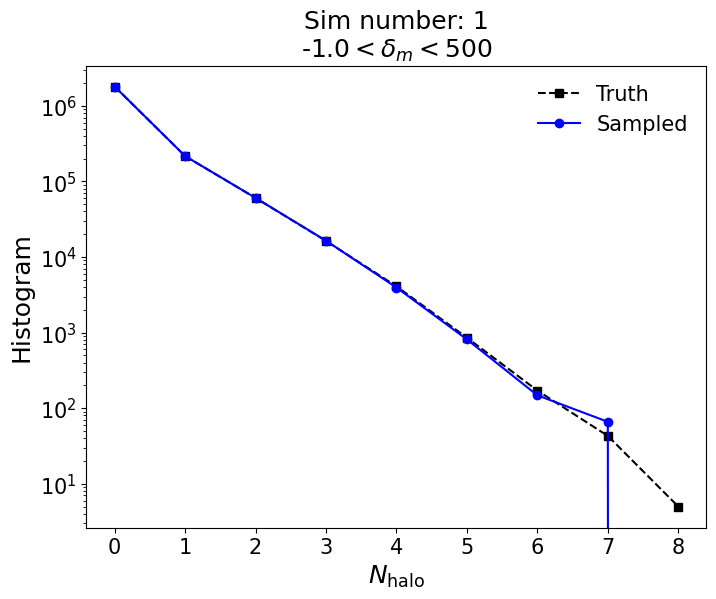

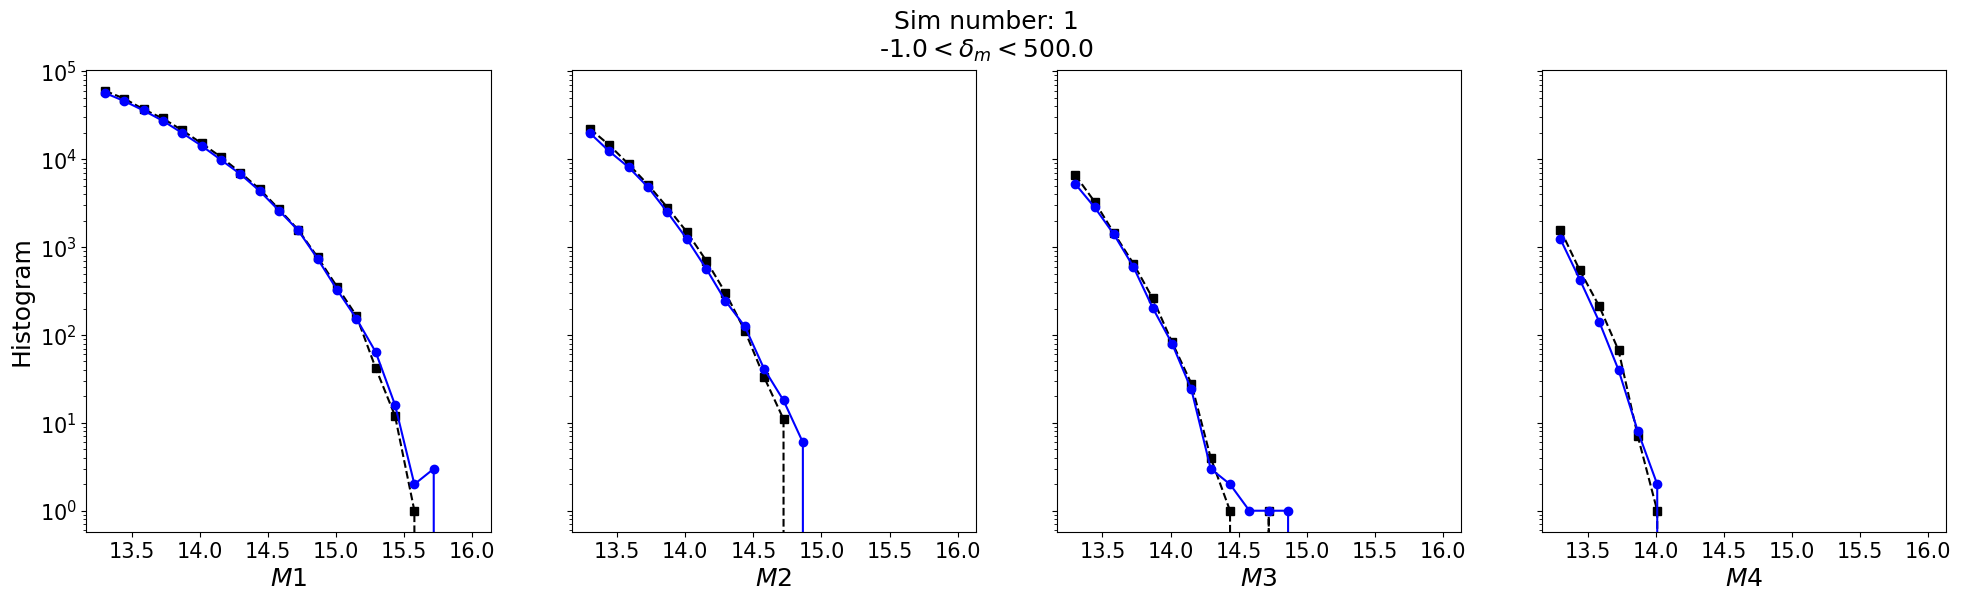

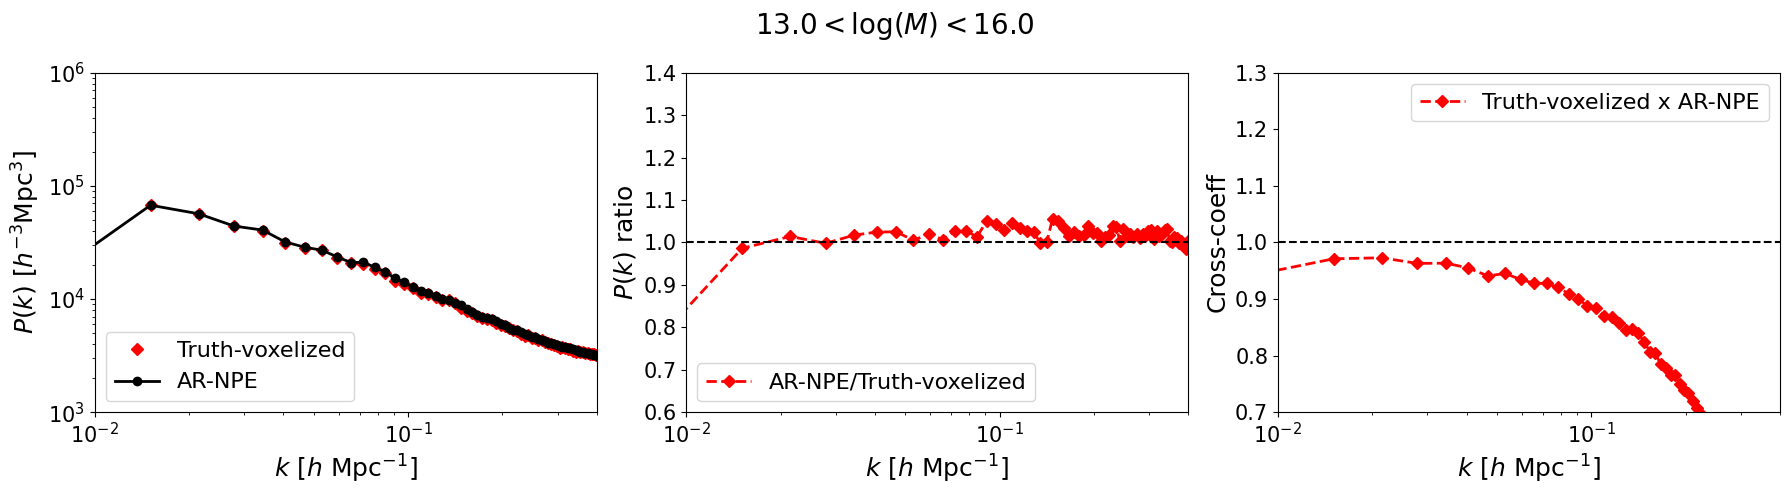

In [41]:
isim_start = 1
isim_end = 2
isim_all = np.arange(isim_start, isim_end).astype(int)
for ji in range(len(isim_all)):
    # now we load the test data
    isim = isim_all[ji]
    print('DOING SIM NUMBER:' + str(isim))
    nstart = 0
    nsims_test = 32
    df_d_all_test, df_d_all_nsh_test, df_Mh_all_test, df_Nh_test = load_density_halo_data_NGP(
        isim, ns_d, nb, nf, nc, z_all, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
        )

    df_d_all_test_FP, df_d_all_nsh_test_FP, df_Mh_all_test_FP, df_Nh_test_FP = load_density_halo_data_NGP(
        isim, ns_d, nb, nf, nc, z_all_FP, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm'
        )

    # things are too big to load all at once, so we load in batches
    nq = nb**3 // nsims_test
    save_subvol_Nhalo = np.zeros((nb**3, nax_h, nax_h, nax_h))
    save_subvol_Nhalo_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
    cond_z0_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
    save_subvol_M1 = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
    save_subvol_M1_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
    save_subvol_Mdiff = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
    save_subvol_Mdiff_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
    mask_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    mask_subvol_Mtot_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))

    nfeatures_M1_tot = 20
    cond_inp_M1_all = np.zeros((nb**3, nax_h, nax_h, nax_h, nfeatures_M1_tot))
    density_out_M1_loc_all_pad = np.zeros((nb**3, nax_h+6, nax_h+6, nax_h+6))
    density_out_M1_loc_all = np.zeros((nb**3, nax_h, nax_h, nax_h))

    nscount = 0
    for jq in range(nq):
        # Load the density data


        # Prepare the density and halo data
        return_dict_test = prep_density_halo_cats(
            df_d_all_test,
            df_d_all_nsh_test,
            df_Mh_all_test,
            df_Nh_test,
            nsims=nsims_test,
            nstart=nscount,
            rescaleM_sub=-0.5
            )
        
        return_dict_test_FP = prep_density_halo_cats(
            df_d_all_test_FP,
            df_d_all_nsh_test_FP,
            df_Mh_all_test_FP,
            df_Nh_test_FP,
            nsims=nsims_test,
            nstart=nscount,
            rescaleM_sub=-0.5
            )    

        cond_tensor_test = torch.Tensor(np.copy(np.array([return_dict_test_FP['df_d_all']]))).cuda(dev)
        cond_nsh_test = np.moveaxis(return_dict_test_FP['df_d_all_nsh'], 1, 4)
        cond_nsh_test = np.array([cond_nsh_test])
        # print(np.array([cond_nsh_test]).shape)
        cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h ** 3), ninp))).cuda(dev)    
        # cond_tensor_nsh_test = torch.Tensor(
        #     np.copy(return_dict_test['df_d_all_nsh'].reshape(nsims_test * (nax_h**3), ninp))
        #     ).cuda(dev)
        mask_tensor_M1_test = torch.Tensor(np.copy(return_dict_test['mask_M1'].reshape(1,nsims_test * (nax_h**3)))).cuda(dev)
        mask_tensor_Mdiff_test = torch.Tensor(
            (return_dict_test['mask_M_diff'].reshape(1,nsims_test * (nax_h**3), ndim_diff))
            ).cuda(dev)

        X_M1_test = torch.Tensor((return_dict_test['M1_halos_all_norm'].reshape(1,nsims_test * (nax_h**3), 1))).cuda(dev)
        X_Nhalo_test = torch.Tensor(return_dict_test['Nhalo_train_mg_arr'].reshape(1,nsims_test * (nax_h**3), 1)).cuda(dev)
        X_Mdiff_test = torch.Tensor(
            return_dict_test['M_diff_halos_all_norm_masked'].reshape(1,nsims_test * (nax_h**3), ndim_diff)
            ).cuda(dev)
        Nhalos_truth_tensor_test = torch.Tensor(((return_dict_test['N_halos_all'].reshape(1,nsims_test * (nax_h**3),
                                                                                        1)))).cuda(dev)
        

        mask_tensor_M1_test_FP = torch.Tensor(np.copy(return_dict_test_FP['mask_M1'].reshape(1,nsims_test * (nax_h**3)))).cuda(dev)
        mask_tensor_Mdiff_test_FP = torch.Tensor(
            (return_dict_test_FP['mask_M_diff'].reshape(1,nsims_test * (nax_h**3), ndim_diff))
            ).cuda(dev)

        X_M1_test_FP = torch.Tensor((return_dict_test_FP['M1_halos_all_norm'].reshape(1,nsims_test * (nax_h**3), 1))).cuda(dev)
        X_Nhalo_test_FP = torch.Tensor(return_dict_test_FP['Nhalo_train_mg_arr'].reshape(1,nsims_test * (nax_h**3), 1)).cuda(dev)
        X_Mdiff_test_FP = torch.Tensor(
            return_dict_test_FP['M_diff_halos_all_norm_masked'].reshape(1,nsims_test * (nax_h**3), ndim_diff)
            ).cuda(dev)
        Nhalos_truth_tensor_test_FP = torch.Tensor(((return_dict_test_FP['N_halos_all'].reshape(1,nsims_test * (nax_h**3),
                                                                                        1)))).cuda(dev)


        Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test, cond_inp_M1_test = model.inverse(
            cond_x=cond_tensor_test,
            cond_x_nsh=cond_tensor_nsh_test,
            use_truth_Nhalo=1-train_Ntot,
                use_truth_M1=1-train_M1,
                use_truth_Mdiff=1-train_Mdiff, 
            mask_Mdiff_truth=mask_tensor_Mdiff_test,
            mask_M1_truth=mask_tensor_M1_test,
            Nhalos_truth=X_Nhalo_test,
            M1_truth=X_M1_test,
            Mdiff_truth=X_Mdiff_test,
            train_Ntot=train_Ntot,
            train_M1=train_M1,
            train_Mdiff=train_Mdiff,
            x_M1_FP=X_M1_test_FP,   
            mask_M1_truth_all_FP=mask_tensor_M1_test_FP 
            )
        Ntot_samp_test = Ntot_samp_test[0][:,np.newaxis]
        # print(Ntot_samp_test.shape)
        save_subvol_Nhalo[nscount:nscount + nsims_test, ...] = Ntot_samp_test.reshape(nsims_test, nax_h, nax_h, nax_h)
        save_subvol_Nhalo_truth[nscount:nscount + nsims_test, ...] = Nhalos_truth_tensor_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        save_subvol_M1[nscount:nscount + nsims_test,
                    ...] = (M1_samp_test[0] * mask_tensor_M1_samp_test[0][:,0]
                            ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)
        save_subvol_M1_truth[nscount:nscount + nsims_test,
                    ...] = (X_M1_test[0][:,0] * mask_tensor_M1_test[0]
                            ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)    
        # cond_inp_M1_all[nscount:nscount + nsims_test,
        #                ...] = cond_inp_M1_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, nfeatures_M1_tot)
        # density_out_M1_loc_all_pad[nscount:nscount + nsims_test,...] = (cond_tensor_test[0,:,0,...].cpu().detach().numpy())
        # density_out_M1_loc_all[nscount:nscount + nsims_test,...] = (cond_nsh_test[0,...,0])

        save_subvol_Mdiff[nscount:nscount + nsims_test,
                        ...] = (M_diff_samp_test[0] * mask_tensor_Mdiff_samp_test[0]
                                ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        save_subvol_Mdiff_truth[nscount:nscount + nsims_test,
                        ...] = (X_Mdiff_test[0] * mask_tensor_Mdiff_test[0]
                                ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        mask_subvol_Mtot[nscount:nscount + nsims_test, ...,
                        0] = mask_tensor_M1_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        mask_subvol_Mtot[
            nscount:nscount + nsims_test, ...,
            1:] = mask_tensor_Mdiff_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)

        mask_subvol_Mtot_truth[nscount:nscount + nsims_test, ...,
                        0] = mask_tensor_M1_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        mask_subvol_Mtot_truth[
            nscount:nscount + nsims_test, ...,
            1:] = mask_tensor_Mdiff_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        
        cond_z0_truth[nscount:nscount + nsims_test, ...] = cond_tensor_nsh_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ninp)[...,0]
        # print(nscount, nscount + nsims_test)

        nscount += nsims_test
        torch.cuda.empty_cache()


    save_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
    for jd in range(ndim_diff + 1):
        if jd == 0:
            save_subvol_Mtot[..., jd] = (save_subvol_M1[..., 0] + 0.5) * (Mmax - Mmin) + Mmin
        else:
            save_subvol_Mtot[...,
                            jd] = (save_subvol_Mtot[..., jd - 1]) - (save_subvol_Mdiff[..., jd - 1]) * (Mmax - Mmin)


    save_subvol_Mtot *= mask_subvol_Mtot

    ind_less_Mmin = save_subvol_Mtot < Mmin
    ind_greater_Mmax = save_subvol_Mtot > Mmax
    save_subvol_Mtot[ind_less_Mmin] = 0.0
    save_subvol_Mtot[ind_greater_Mmax] = 0.0


    save_subvol_Mtot_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
    for jd in range(ndim_diff + 1):
        if jd == 0:
            save_subvol_Mtot_truth[..., jd] = (save_subvol_M1_truth[..., 0] + 0.5) * (Mmax - Mmin) + Mmin
        else:
            save_subvol_Mtot_truth[...,
                            jd] = (save_subvol_Mtot_truth[..., jd - 1]) - (save_subvol_Mdiff_truth[..., jd - 1]) * (Mmax - Mmin)


    save_subvol_Mtot_truth *= mask_subvol_Mtot_truth
                

    sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
    # load the halo data
    fname = sdir + '/' + str(isim) + '/halos_subvol_res_' + str(ns_h) + '_z=0.pk'
    df_h = pk.load(open(fname, 'rb'))
    # This has information on the halo mass for all the halos in the voxel
    df_Mh_all_truth = df_h['M_halos']
    df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
    # This has information on the number of halos in the voxel
    df_Nh_truth = df_h['N_halos']

    fname = sdir + '/' + str(isim) + '/halos_full_res_' + str(ns_h) + '_z=0.pk'
    df_h = pk.load(open(fname, 'rb'))
    df_Mh_all_truth_comb, df_Nh_truth_comb = df_h['M_halos_combined'], df_h['N_halos_combined']

    delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1
    # delta_min_p, delta_max_p =1.0, 1.5
    delta_min_p, delta_max_p= -1.0, 500
    # delta_min_p, delta_max_p = 2, 5
    # delta_min_p, delta_max_p = -0.5, -0.0
    # delta_min_p, delta_max_p = 1.0, 2.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    pl.figure(figsize=(8,6))
    bin_cents = np.array([0,1,2,3,4,5,6,7,8])
    bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
    bin_edges = np.insert(bin_edges,0, -0.5)
    bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] + 0.5)
    hist_truth, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    # _ = pl.hist(df_Nh_truth[indsel_dp].flatten(), histtype='step', bins=[0,1,2,3,4,5,6,7,8], label='Truth')
    pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label='Truth')
    hist_samp, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    # _ = pl.hist(, bins=[0,1,2,3,4,5,6,7,8], label='Sampled')
    pl.plot(bin_cents, hist_samp, marker='o', color='b', ls='-', label='Sampled')
    pl.yscale('log')
    pl.legend(fontsize=15, frameon=False)
    pl.tick_params(axis='both', which='major', labelsize=15)
    pl.tick_params(axis='both', which='minor', labelsize=15)
    pl.xlabel(r'$N_{\rm halo}$', size=18)
    pl.ylabel('Histogram', size=18)
    pl.title(str('Sim number: ') + str(isim) + '\n' + str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)


    # make a four panel figure with idim going from 0 to 3 in the rows:

    delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1
    delta_min_p, delta_max_p = -1.0, 500.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    bin_cents = np.linspace(13.3, 16.0, 20)
    bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
    delta_b = 0.5*(bin_cents[1] - bin_cents[0])
    bin_edges = np.insert(bin_edges,0, bin_cents[0] - delta_b)
    bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] - delta_b)

    fig, ax = pl.subplots(1,4, figsize=(24,6), sharey=True, sharex=True)
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges)
        ax[idim].plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label='Truth')
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges)
        ax[idim].plot(bin_cents, hist_sampled, marker='o', color='b', ls='-', label='Sampled')
        ax[idim].set_yscale('log')
        ax[idim].tick_params(axis='both', which='major', labelsize=15)
        ax[idim].tick_params(axis='both', which='minor', labelsize=15)
        
        if idim == 0:
            ax[idim].set_ylabel('Histogram', size=18)
        ax[idim].set_xlabel(r'$M$' + str(idim + 1), size=18)
    pl.suptitle(str('Sim number: ') + str(isim) + '\n' + str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)




    # create empty arrays for Nhalos and M_halos
    Nhalos = np.zeros((ns_h, ns_h, ns_h))
    M_halos = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))
    M_halos_truth = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

    subvol_size = ns_h // nb

    ind_cart_lin = {}
    ind_lin_cart = {}
    jc = 0
    from tqdm import tqdm
    for jx in tqdm(range(nb)):
        for jy in range(nb):
            for jz in range(nb):
                # get the sub-cube
                ind_lin_cart[(jx, jy, jz)] = jc
                ind_cart_lin[jc] = [jx, jy, jz]
                jc += 1
                

    # iterate over subvolumes
    jc = 0
    for jx in range(nb):
        for jy in range(nb):
            for jz in range(nb):
                Nhalos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                    jz * subvol_size:(jz + 1) * subvol_size] = save_subvol_Nhalo[ind_lin_cart[(jx, jy, jz)]]

                M_halos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                        jz * subvol_size:(jz + 1) * subvol_size, :] = save_subvol_Mtot[ind_lin_cart[(jx, jy, jz)]]
                
                
                jc += 1
                
                
    
    # create empty arrays for Nhalos and M_halos
    Nhalos_truth_recomb = np.zeros((ns_h, ns_h, ns_h))
    M_halos_truth_recomb = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

    subvol_size = ns_h // nb

    ind_cart_lin = {}
    ind_lin_cart = {}
    jc = 0
    from tqdm import tqdm
    for jx in tqdm(range(nb)):
        for jy in range(nb):
            for jz in range(nb):
                # get the sub-cube
                ind_lin_cart[(jx, jy, jz)] = jc
                ind_cart_lin[jc] = [jx, jy, jz]
                jc += 1
                

    # iterate over subvolumes
    jc = 0
    for jx in range(nb):
        for jy in range(nb):
            for jz in range(nb):
                Nhalos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                    jz * subvol_size:(jz + 1) * subvol_size] = df_Nh_truth[ind_lin_cart[(jx, jy, jz)]]

                M_halos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                        jz * subvol_size:(jz + 1) * subvol_size, :] = df_Mh_all_truth[ind_lin_cart[(jx, jy, jz)]]
                
                
                jc += 1
                

    # create the meshgrid
    zv = 0.0
    av = 1. / (1 + zv)
    xall = (np.linspace(0, 1000, ns_h + 1))
    xarray = av * 0.5 * (xall[1:] + xall[:-1])
    yarray = np.copy(xarray)
    zarray = np.copy(xarray)
    x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')


    # create the meshgrid
    zv = 0.0
    av = 1. / (1 + zv)
    xall = (np.linspace(0, 1000, ns_h + 1))
    xarray = av * 0.5 * (xall[1:] + xall[:-1])
    dx = (xall[1] - xall[0])
    yarray = np.copy(xarray)
    zarray = np.copy(xarray)
    x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

    x_h_mock, y_h_mock, z_h_mock, lgM_mock = [], [], [], []
    k = 0
    for jx in range(ns_h):
        for jy in range(ns_h):
            for jz in range(ns_h):
                    Nh_vox = int(Nhalos[jx, jy, jz])
                    if Nh_vox > 0:
                        # for jh in range(Nh_vox):
                        # x_h_mock.append(x_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                        # y_h_mock.append(y_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                        # z_h_mock.append(z_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                        x_h_mock.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                        y_h_mock.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                        z_h_mock.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                        
                        lgM_mock.append((M_halos[jx, jy, jz, :Nh_vox]))
                        k += Nh_vox

    # convert to numpy arrays
    x_h_mock = np.concatenate(x_h_mock)
    y_h_mock = np.concatenate(y_h_mock)
    z_h_mock = np.concatenate(z_h_mock)
    pos_h_mock = np.vstack((x_h_mock, y_h_mock, z_h_mock)).T
    lgMass_mock = np.concatenate(lgM_mock)
    # convert to float data type
    pos_h_mock = pos_h_mock.astype('float32')
    lgMass_mock = lgMass_mock.astype('float32')


    sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
    # load the halo data
    fname = sdir + '/' + str(isim) + '/halos_subvol_res_' + str(ns_h) + '_z=0.pk'
    df_h = pk.load(open(fname, 'rb'))
    # This has information on the halo mass for all the halos in the voxel
    df_Mh_all_truth = df_h['M_halos']
    df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
    # This has information on the number of halos in the voxel
    df_Nh_truth = df_h['N_halos']

    fname = sdir + '/' + str(isim) + '/halos_full_res_' + str(ns_h) + '_z=0.pk'
    df_h = pk.load(open(fname, 'rb'))
    df_Mh_all_truth_comb, df_Nh_truth_comb = df_h['M_halos_combined'], df_h['N_halos_combined']

    # create the meshgrid
    zv = 0.0
    av = 1. / (1 + zv)
    xall = (np.linspace(0, 1000, ns_h + 1))
    xarray = av * 0.5 * (xall[1:] + xall[:-1])
    dx = (xall[1] - xall[0])
    yarray = np.copy(xarray)
    zarray = np.copy(xarray)
    x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

    x_h_truth, y_h_truth, z_h_truth, lgM_truth = [], [], [], []
    for jx in range(ns_h):
        for jy in range(ns_h):
            for jz in range(ns_h):
                    Nh_vox = int(df_Nh_truth_comb[jx, jy, jz])
                    if Nh_vox > 0:
                        # for jh in range(Nh_vox):
                        # x_h_mock.append(x_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                        # y_h_mock.append(y_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                        # z_h_mock.append(z_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                        x_h_truth.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                        y_h_truth.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                        z_h_truth.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                        
                        lgM_truth.append((df_Mh_all_truth_comb[jx, jy, jz, :Nh_vox]))

    # convert to numpy arrays
    x_h_truth = np.concatenate(x_h_truth)
    y_h_truth = np.concatenate(y_h_truth)
    z_h_truth = np.concatenate(z_h_truth)
    pos_h_truth = np.vstack((x_h_truth, y_h_truth, z_h_truth)).T
    lgMass_truth = np.concatenate(lgM_truth)
    # convert to float data type
    pos_h_truth = pos_h_truth.astype('float32')
    lgMass_truth = lgMass_truth.astype('float32')

    grid    = ns_h    #the 3D field will have grid x grid x grid voxels
    BoxSize = 1000.0 #Mpc/h ; size of box
    MAS     = 'NGP'  #mass-assigment scheme
    verbose = True   #print information on progress
    Mmin_Pk, Mmax_Pk = 13.0, 16.0

    indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
    mesh_truth2 = np.zeros((grid, grid, grid), dtype=np.float32)
    pos_truth2 = (pos_h_truth[indsel_Pk_truth,...]).astype(np.float32)
    MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS)
    mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float64);  mesh_truth2 -= 1.0
    Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=None, threads=1)


    indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
    mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
    pos_mock = (pos_h_mock[indsel_Pk_mock,...]).astype(np.float32)
    MASL.MA(pos_mock, mesh_mock, BoxSize, MAS)
    mesh_mock /= np.mean(mesh_mock, dtype=np.float64);  mesh_mock -= 1.0
    Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=1)    


    Pk_mockxtruth2 = PKL.XPk([mesh_truth2,mesh_mock], BoxSize, axis=0, MAS=[None, None], threads=1)



    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), sharex=True)
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    axes[0].loglog(Pk_truth2.k3D, Pk_truth2.Pk[:,0], label='Truth-voxelized', color='r', ls='', marker='D', lw=2.0)
    axes[0].loglog(Pk_mock.k3D, Pk_mock.Pk[:,0], label='AR-NPE', color='k', ls='-', marker='o', lw=2.0)
    # axes[0].set_ylim(1e3, 1e5)
    axes[0].set_ylim(1e3, 1e6)

    axes[0].legend(fontsize=16, loc='lower left')
    axes[0].set_ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]", size=18)
    axes[0].tick_params(axis='both', labelsize=15)
    axes[1].plot(Pk_mock.k3D, Pk_mock.Pk[:,0]/ Pk_truth2.Pk[:,0], label='AR-NPE/Truth-voxelized', color='r', ls='--', marker='D', lw=2.0)
    axes[1].legend(fontsize=16, loc='lower left')
    axes[1].set_ylabel(r"$P(k)$ ratio", size=18)
    axes[1].axhline(1.0, ls='--', color='k')
    axes[1].set_ylim(0.6, 1.4)
    axes[1].tick_params(axis='both', labelsize=15)

    axes[2].plot(Pk_mockxtruth2.k3D, (Pk_mockxtruth2.XPk[:,0,0]) / (((Pk_mock.Pk[:,0]) * (Pk_truth2.Pk[:,0])) ** 0.5), label='Truth-voxelized x AR-NPE', color='r', ls='--', marker='D', lw=2.0)
    axes[2].set_ylim(0.7, 1.3)
    axes[2].axhline(1.0, ls='--', color='k')
    axes[2].set_xscale('log')
    axes[2].legend(fontsize=16)
    axes[0].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=18)
    axes[1].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=18)
    axes[2].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=18)
    axes[2].set_ylabel(r"Cross-coeff", size=18)
    axes[2].tick_params(axis='both', labelsize=15)
    axes[2].set_xlim(0.01, 0.4)
    plt.suptitle(str(Mmin_Pk) + r'$< \log(M) <$' + str(Mmax_Pk), size=20)
    plt.tight_layout()





                    


In [44]:
# from tq
isim_start = 0
isim_end = 100
isim_all = np.arange(isim_start, isim_end).astype(int)
for ji in range(len(isim_all)):
    saved_all_jsim = {}
    # now we load the test data
    isim = isim_all[ji]
    print('DOING SIM NUMBER:' + str(isim))
    nstart = 0
    nsims_test = 32
    df_d_all_test, df_d_all_nsh_test, df_Mh_all_test, df_Nh_test = load_density_halo_data_NGP(
        isim, ns_d, nb, nf, nc, z_all, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
        )

    df_d_all_test_FP, df_d_all_nsh_test_FP, df_Mh_all_test_FP, df_Nh_test_FP = load_density_halo_data_NGP(
        isim, ns_d, nb, nf, nc, z_all_FP, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm'
        )

    # things are too big to load all at once, so we load in batches
    nq = nb**3 // nsims_test
    save_subvol_Nhalo = np.zeros((nb**3, nax_h, nax_h, nax_h))
    save_subvol_Nhalo_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
    cond_z0_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
    save_subvol_M1 = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
    save_subvol_M1_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
    save_subvol_Mdiff = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
    save_subvol_Mdiff_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
    mask_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    mask_subvol_Mtot_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))

    nfeatures_M1_tot = 20
    cond_inp_M1_all = np.zeros((nb**3, nax_h, nax_h, nax_h, nfeatures_M1_tot))
    density_out_M1_loc_all_pad = np.zeros((nb**3, nax_h+6, nax_h+6, nax_h+6))
    density_out_M1_loc_all = np.zeros((nb**3, nax_h, nax_h, nax_h))

    nscount = 0
    for jq in range(nq):
        # Load the density data


        # Prepare the density and halo data
        return_dict_test = prep_density_halo_cats(
            df_d_all_test,
            df_d_all_nsh_test,
            df_Mh_all_test,
            df_Nh_test,
            nsims=nsims_test,
            nstart=nscount,
            rescaleM_sub=-0.5
            )
        
        return_dict_test_FP = prep_density_halo_cats(
            df_d_all_test_FP,
            df_d_all_nsh_test_FP,
            df_Mh_all_test_FP,
            df_Nh_test_FP,
            nsims=nsims_test,
            nstart=nscount,
            rescaleM_sub=-0.5
            )    

        cond_tensor_test = torch.Tensor(np.copy(np.array([return_dict_test_FP['df_d_all']]))).cuda(dev)
        cond_nsh_test = np.moveaxis(return_dict_test_FP['df_d_all_nsh'], 1, 4)
        cond_nsh_test = np.array([cond_nsh_test])
        # print(np.array([cond_nsh_test]).shape)
        cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h ** 3), ninp))).cuda(dev)    
        # cond_tensor_nsh_test = torch.Tensor(
        #     np.copy(return_dict_test['df_d_all_nsh'].reshape(nsims_test * (nax_h**3), ninp))
        #     ).cuda(dev)
        mask_tensor_M1_test = torch.Tensor(np.copy(return_dict_test['mask_M1'].reshape(1,nsims_test * (nax_h**3)))).cuda(dev)
        mask_tensor_Mdiff_test = torch.Tensor(
            (return_dict_test['mask_M_diff'].reshape(1,nsims_test * (nax_h**3), ndim_diff))
            ).cuda(dev)

        X_M1_test = torch.Tensor((return_dict_test['M1_halos_all_norm'].reshape(1,nsims_test * (nax_h**3), 1))).cuda(dev)
        X_Nhalo_test = torch.Tensor(return_dict_test['Nhalo_train_mg_arr'].reshape(1,nsims_test * (nax_h**3), 1)).cuda(dev)
        X_Mdiff_test = torch.Tensor(
            return_dict_test['M_diff_halos_all_norm_masked'].reshape(1,nsims_test * (nax_h**3), ndim_diff)
            ).cuda(dev)
        Nhalos_truth_tensor_test = torch.Tensor(((return_dict_test['N_halos_all'].reshape(1,nsims_test * (nax_h**3),
                                                                                        1)))).cuda(dev)
        

        mask_tensor_M1_test_FP = torch.Tensor(np.copy(return_dict_test_FP['mask_M1'].reshape(1,nsims_test * (nax_h**3)))).cuda(dev)
        mask_tensor_Mdiff_test_FP = torch.Tensor(
            (return_dict_test_FP['mask_M_diff'].reshape(1,nsims_test * (nax_h**3), ndim_diff))
            ).cuda(dev)

        X_M1_test_FP = torch.Tensor((return_dict_test_FP['M1_halos_all_norm'].reshape(1,nsims_test * (nax_h**3), 1))).cuda(dev)
        X_Nhalo_test_FP = torch.Tensor(return_dict_test_FP['Nhalo_train_mg_arr'].reshape(1,nsims_test * (nax_h**3), 1)).cuda(dev)
        X_Mdiff_test_FP = torch.Tensor(
            return_dict_test_FP['M_diff_halos_all_norm_masked'].reshape(1,nsims_test * (nax_h**3), ndim_diff)
            ).cuda(dev)
        Nhalos_truth_tensor_test_FP = torch.Tensor(((return_dict_test_FP['N_halos_all'].reshape(1,nsims_test * (nax_h**3),
                                                                                        1)))).cuda(dev)


        Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test, cond_inp_M1_test = model.inverse(
            cond_x=cond_tensor_test,
            cond_x_nsh=cond_tensor_nsh_test,
            use_truth_Nhalo=1-train_Ntot,
                use_truth_M1=1-train_M1,
                use_truth_Mdiff=1-train_Mdiff, 
            mask_Mdiff_truth=mask_tensor_Mdiff_test,
            mask_M1_truth=mask_tensor_M1_test,
            Nhalos_truth=X_Nhalo_test,
            M1_truth=X_M1_test,
            Mdiff_truth=X_Mdiff_test,
            train_Ntot=train_Ntot,
            train_M1=train_M1,
            train_Mdiff=train_Mdiff,
            x_M1_FP=X_M1_test_FP,   
            mask_M1_truth_all_FP=mask_tensor_M1_test_FP 
            )
        Ntot_samp_test = Ntot_samp_test[0][:,np.newaxis]
        # print(Ntot_samp_test.shape)
        save_subvol_Nhalo[nscount:nscount + nsims_test, ...] = Ntot_samp_test.reshape(nsims_test, nax_h, nax_h, nax_h)
        save_subvol_Nhalo_truth[nscount:nscount + nsims_test, ...] = Nhalos_truth_tensor_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        save_subvol_M1[nscount:nscount + nsims_test,
                    ...] = (M1_samp_test[0] * mask_tensor_M1_samp_test[0][:,0]
                            ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)
        save_subvol_M1_truth[nscount:nscount + nsims_test,
                    ...] = (X_M1_test[0][:,0] * mask_tensor_M1_test[0]
                            ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)    
        # cond_inp_M1_all[nscount:nscount + nsims_test,
        #                ...] = cond_inp_M1_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, nfeatures_M1_tot)
        # density_out_M1_loc_all_pad[nscount:nscount + nsims_test,...] = (cond_tensor_test[0,:,0,...].cpu().detach().numpy())
        # density_out_M1_loc_all[nscount:nscount + nsims_test,...] = (cond_nsh_test[0,...,0])

        save_subvol_Mdiff[nscount:nscount + nsims_test,
                        ...] = (M_diff_samp_test[0] * mask_tensor_Mdiff_samp_test[0]
                                ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        save_subvol_Mdiff_truth[nscount:nscount + nsims_test,
                        ...] = (X_Mdiff_test[0] * mask_tensor_Mdiff_test[0]
                                ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        mask_subvol_Mtot[nscount:nscount + nsims_test, ...,
                        0] = mask_tensor_M1_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        mask_subvol_Mtot[
            nscount:nscount + nsims_test, ...,
            1:] = mask_tensor_Mdiff_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)

        mask_subvol_Mtot_truth[nscount:nscount + nsims_test, ...,
                        0] = mask_tensor_M1_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        mask_subvol_Mtot_truth[
            nscount:nscount + nsims_test, ...,
            1:] = mask_tensor_Mdiff_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        
        cond_z0_truth[nscount:nscount + nsims_test, ...] = cond_tensor_nsh_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ninp)[...,0]
        # print(nscount, nscount + nsims_test)

        nscount += nsims_test
        torch.cuda.empty_cache()


    save_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
    for jd in range(ndim_diff + 1):
        if jd == 0:
            save_subvol_Mtot[..., jd] = (save_subvol_M1[..., 0] + 0.5) * (Mmax - Mmin) + Mmin
        else:
            save_subvol_Mtot[...,
                            jd] = (save_subvol_Mtot[..., jd - 1]) - (save_subvol_Mdiff[..., jd - 1]) * (Mmax - Mmin)


    save_subvol_Mtot *= mask_subvol_Mtot

    ind_less_Mmin = save_subvol_Mtot < Mmin
    ind_greater_Mmax = save_subvol_Mtot > Mmax
    save_subvol_Mtot[ind_less_Mmin] = 0.0
    save_subvol_Mtot[ind_greater_Mmax] = 0.0


    save_subvol_Mtot_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
    for jd in range(ndim_diff + 1):
        if jd == 0:
            save_subvol_Mtot_truth[..., jd] = (save_subvol_M1_truth[..., 0] + 0.5) * (Mmax - Mmin) + Mmin
        else:
            save_subvol_Mtot_truth[...,
                            jd] = (save_subvol_Mtot_truth[..., jd - 1]) - (save_subvol_Mdiff_truth[..., jd - 1]) * (Mmax - Mmin)


    save_subvol_Mtot_truth *= mask_subvol_Mtot_truth
                

    sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
    # load the halo data
    fname = sdir + '/' + str(isim) + '/halos_subvol_res_' + str(ns_h) + '_z=0.pk'
    df_h = pk.load(open(fname, 'rb'))
    # This has information on the halo mass for all the halos in the voxel
    df_Mh_all_truth = df_h['M_halos']
    df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
    # This has information on the number of halos in the voxel
    df_Nh_truth = df_h['N_halos']

    fname = sdir + '/' + str(isim) + '/halos_full_res_' + str(ns_h) + '_z=0.pk'
    df_h = pk.load(open(fname, 'rb'))
    df_Mh_all_truth_comb, df_Nh_truth_comb = df_h['M_halos_combined'], df_h['N_halos_combined']

    delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1

    bin_cents = np.array([0,1,2,3,4,5,6,7,8])
    bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
    bin_edges = np.insert(bin_edges,0, -0.5)
    bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] + 0.5)
    saved_all_jsim['Nhalo_bin_cents'] = bin_cents
    saved_all_jsim['Nhalo_bin_edges'] = bin_edges

    delta_min_p, delta_max_p= -1.0, 500
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_all, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_all, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_all_Nhalo'] = hist_truth_all
    saved_all_jsim['hist_samp_all_Nhalo'] = hist_samp_all

    delta_min_p, delta_max_p= -1.0, 0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_low, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_low, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_low_Nhalo'] = hist_truth_low
    saved_all_jsim['hist_samp_low_Nhalo'] = hist_samp_low

    delta_min_p, delta_max_p= 0.0, 2.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_mid, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_mid, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_mid_Nhalo'] = hist_truth_mid
    saved_all_jsim['hist_samp_mid_Nhalo'] = hist_samp_mid

    delta_min_p, delta_max_p= 2.0, 500
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_high, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_high, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_high_Nhalo'] = hist_truth_high
    saved_all_jsim['hist_samp_high_Nhalo'] = hist_samp_high


    delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1
    bin_cents_M = np.linspace(13.3, 16.0, 20)
    bin_edges_M = 0.5*(bin_cents_M[1:] + bin_cents_M[:-1])
    delta_b = 0.5*(bin_cents_M[1] - bin_cents_M[0])
    bin_edges_M = np.insert(bin_edges_M,0, bin_cents_M[0] - delta_b)
    bin_edges_M = np.insert(bin_edges_M,len(bin_edges_M), bin_cents_M[-1] - delta_b)
    saved_all_jsim['Mhalo_bin_cents'] = bin_cents_M
    saved_all_jsim['Mhalo_bin_edges'] = bin_edges_M


    delta_min_p, delta_max_p = -1.0, 500.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_all = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_all = np.zeros((4, len(bin_cents_M)))    
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges)
        hist_M_truth_all[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges)
        hist_M_samp_all[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_all_Mhalo'] = hist_M_truth_all
    saved_all_jsim['hist_samp_all_Mhalo'] = hist_M_samp_all

    delta_min_p, delta_max_p = -1.0, 0.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_low = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_low = np.zeros((4, len(bin_cents_M)))
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges)
        hist_M_truth_low[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges)
        hist_M_samp_low[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_low_Mhalo'] = hist_M_truth_low
    saved_all_jsim['hist_samp_low_Mhalo'] = hist_M_samp_low

    delta_min_p, delta_max_p = 0.0, 2.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_mid = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_mid = np.zeros((4, len(bin_cents_M)))
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges)
        hist_M_truth_mid[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges)
        hist_M_samp_mid[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_mid_Mhalo'] = hist_M_truth_mid
    saved_all_jsim['hist_samp_mid_Mhalo'] = hist_M_samp_mid

    delta_min_p, delta_max_p = 2.0, 500.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_high = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_high = np.zeros((4, len(bin_cents_M)))
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges)
        hist_M_truth_high[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges)
        hist_M_samp_high[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_high_Mhalo'] = hist_M_truth_high
    saved_all_jsim['hist_samp_high_Mhalo'] = hist_M_samp_high


    # create empty arrays for Nhalos and M_halos
    Nhalos = np.zeros((ns_h, ns_h, ns_h))
    M_halos = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))
    M_halos_truth = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

    subvol_size = ns_h // nb

    ind_cart_lin = {}
    ind_lin_cart = {}
    jc = 0
    from tqdm import tqdm
    for jx in tqdm(range(nb)):
        for jy in range(nb):
            for jz in range(nb):
                # get the sub-cube
                ind_lin_cart[(jx, jy, jz)] = jc
                ind_cart_lin[jc] = [jx, jy, jz]
                jc += 1
                

    # iterate over subvolumes
    jc = 0
    for jx in range(nb):
        for jy in range(nb):
            for jz in range(nb):
                Nhalos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                    jz * subvol_size:(jz + 1) * subvol_size] = save_subvol_Nhalo[ind_lin_cart[(jx, jy, jz)]]

                M_halos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                        jz * subvol_size:(jz + 1) * subvol_size, :] = save_subvol_Mtot[ind_lin_cart[(jx, jy, jz)]]
                
                
                jc += 1
                
                
    
    # create empty arrays for Nhalos and M_halos
    Nhalos_truth_recomb = np.zeros((ns_h, ns_h, ns_h))
    M_halos_truth_recomb = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

    subvol_size = ns_h // nb

    ind_cart_lin = {}
    ind_lin_cart = {}
    jc = 0
    from tqdm import tqdm
    for jx in tqdm(range(nb)):
        for jy in range(nb):
            for jz in range(nb):
                # get the sub-cube
                ind_lin_cart[(jx, jy, jz)] = jc
                ind_cart_lin[jc] = [jx, jy, jz]
                jc += 1
                

    # iterate over subvolumes
    jc = 0
    for jx in range(nb):
        for jy in range(nb):
            for jz in range(nb):
                Nhalos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                    jz * subvol_size:(jz + 1) * subvol_size] = df_Nh_truth[ind_lin_cart[(jx, jy, jz)]]

                M_halos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                        jz * subvol_size:(jz + 1) * subvol_size, :] = df_Mh_all_truth[ind_lin_cart[(jx, jy, jz)]]
                
                
                jc += 1
                

    # create the meshgrid
    zv = 0.0
    av = 1. / (1 + zv)
    xall = (np.linspace(0, 1000, ns_h + 1))
    xarray = av * 0.5 * (xall[1:] + xall[:-1])
    yarray = np.copy(xarray)
    zarray = np.copy(xarray)
    x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')


    # create the meshgrid
    zv = 0.0
    av = 1. / (1 + zv)
    xall = (np.linspace(0, 1000, ns_h + 1))
    xarray = av * 0.5 * (xall[1:] + xall[:-1])
    dx = (xall[1] - xall[0])
    yarray = np.copy(xarray)
    zarray = np.copy(xarray)
    x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

    x_h_mock, y_h_mock, z_h_mock, lgM_mock = [], [], [], []
    k = 0
    for jx in range(ns_h):
        for jy in range(ns_h):
            for jz in range(ns_h):
                    Nh_vox = int(Nhalos[jx, jy, jz])
                    if Nh_vox > 0:
                        x_h_mock.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                        y_h_mock.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                        z_h_mock.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                        
                        lgM_mock.append((M_halos[jx, jy, jz, :Nh_vox]))
                        k += Nh_vox

    # convert to numpy arrays
    x_h_mock = np.concatenate(x_h_mock)
    y_h_mock = np.concatenate(y_h_mock)
    z_h_mock = np.concatenate(z_h_mock)
    pos_h_mock = np.vstack((x_h_mock, y_h_mock, z_h_mock)).T
    lgMass_mock = np.concatenate(lgM_mock)
    # convert to float data type
    pos_h_mock = pos_h_mock.astype('float32')
    lgMass_mock = lgMass_mock.astype('float32')


    sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
    # load the halo data
    fname = sdir + '/' + str(isim) + '/halos_subvol_res_' + str(ns_h) + '_z=0.pk'
    df_h = pk.load(open(fname, 'rb'))
    # This has information on the halo mass for all the halos in the voxel
    df_Mh_all_truth = df_h['M_halos']
    df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
    # This has information on the number of halos in the voxel
    df_Nh_truth = df_h['N_halos']

    fname = sdir + '/' + str(isim) + '/halos_full_res_' + str(ns_h) + '_z=0.pk'
    df_h = pk.load(open(fname, 'rb'))
    df_Mh_all_truth_comb, df_Nh_truth_comb = df_h['M_halos_combined'], df_h['N_halos_combined']

    # create the meshgrid
    zv = 0.0
    av = 1. / (1 + zv)
    xall = (np.linspace(0, 1000, ns_h + 1))
    xarray = av * 0.5 * (xall[1:] + xall[:-1])
    dx = (xall[1] - xall[0])
    yarray = np.copy(xarray)
    zarray = np.copy(xarray)
    x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

    x_h_truth, y_h_truth, z_h_truth, lgM_truth = [], [], [], []
    for jx in range(ns_h):
        for jy in range(ns_h):
            for jz in range(ns_h):
                    Nh_vox = int(df_Nh_truth_comb[jx, jy, jz])
                    if Nh_vox > 0:
                        x_h_truth.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                        y_h_truth.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                        z_h_truth.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                        
                        lgM_truth.append((df_Mh_all_truth_comb[jx, jy, jz, :Nh_vox]))

    # convert to numpy arrays
    x_h_truth = np.concatenate(x_h_truth)
    y_h_truth = np.concatenate(y_h_truth)
    z_h_truth = np.concatenate(z_h_truth)
    pos_h_truth = np.vstack((x_h_truth, y_h_truth, z_h_truth)).T
    lgMass_truth = np.concatenate(lgM_truth)
    # convert to float data type
    pos_h_truth = pos_h_truth.astype('float32')
    lgMass_truth = lgMass_truth.astype('float32')

    grid    = ns_h    #the 3D field will have grid x grid x grid voxels
    BoxSize = 1000.0 #Mpc/h ; size of box
    MAS     = 'NGP'  #mass-assigment scheme
    verbose = True   #print information on progress

    Mmin_Pk_all = np.array([13.0, 13.0, 13.5, 14.0, 14.5])
    Mmax_Pk_all = np.array([16.0, 13.5, 14.0, 14.5, 15.0])

    saved_Pk_Bk = {}

    for j in range(len(Mmin_Pk_all)):
        saved_j = {}
        Mmin_Pk, Mmax_Pk = Mmin_Pk_all[j], Mmax_Pk_all[j]
        indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
        mesh_truth2 = np.zeros((grid, grid, grid), dtype=np.float32)
        pos_truth2 = (pos_h_truth[indsel_Pk_truth,...]).astype(np.float32)
        MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS)
        mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float64);  mesh_truth2 -= 1.0
        Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=None, threads=1)

        indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
        mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
        pos_mock = (pos_h_mock[indsel_Pk_mock,...]).astype(np.float32)
        MASL.MA(pos_mock, mesh_mock, BoxSize, MAS)
        mesh_mock /= np.mean(mesh_mock, dtype=np.float64);  mesh_mock -= 1.0
        Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=1)    

        Pk_mockxtruth2 = PKL.XPk([mesh_truth2,mesh_mock], BoxSize, axis=0, MAS=[None, None], threads=1)

        saved_j['Pk_truth'] = Pk_truth2.Pk[:,0]
        saved_j['Pk_mock'] = Pk_mock.Pk[:,0]
        saved_j['Pk_mockxtruth'] = Pk_mockxtruth2.XPk[:,0,0]
        saved_j['k_Pk'] = Pk_mockxtruth2.k3D
        

        BoxSize = 1000.0 #Size of the density field in Mpc/h
        threads = 1
        theta   = np.linspace(0, np.pi, 16) #array with the angles between k1 and k2
        saved_j['theta'] = theta

        k1 = 0.03
        k2 = 0.03
        BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
        Bk_truth_k0p03  = BBk.B     #bispectrum
        Qk_truth_k0p03  = BBk.Q     #reduced bispectrum
        BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
        Bk_mock_k0p03  = BBk.B     #bispectrum
        Qk_mock_k0p03  = BBk.Q     #reduced bispectrum

        saved_j['Bk_truth_k0p03'] = Bk_truth_k0p03
        saved_j['Qk_truth_k0p03'] = Qk_truth_k0p03
        saved_j['Bk_mock_k0p03'] = Bk_mock_k0p03
        saved_j['Qk_mock_k0p03'] = Qk_mock_k0p03


        k1 = 0.06
        k2 = 0.06
        BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
        Bk_truth_k0p06  = BBk.B     #bispectrum
        Qk_truth_k0p06  = BBk.Q     #reduced bispectrum
        BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
        Bk_mock_k0p06  = BBk.B     #bispectrum
        Qk_mock_k0p06  = BBk.Q     #reduced bispectrum

        saved_j['Bk_truth_k0p06'] = Bk_truth_k0p06
        saved_j['Qk_truth_k0p06'] = Qk_truth_k0p06
        saved_j['Bk_mock_k0p06'] = Bk_mock_k0p06
        saved_j['Qk_mock_k0p06'] = Qk_mock_k0p06

        k1 = 0.1
        k2 = 0.1
        BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
        Bk_truth_k0p1  = BBk.B     #bispectrum
        Qk_truth_k0p1  = BBk.Q     #reduced bispectrum
        BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
        Bk_mock_k0p1  = BBk.B     #bispectrum
        Qk_mock_k0p1  = BBk.Q     #reduced bispectrum

        saved_j['Bk_truth_k0p1'] = Bk_truth_k0p1
        saved_j['Qk_truth_k0p1'] = Qk_truth_k0p1
        saved_j['Bk_mock_k0p1'] = Bk_mock_k0p1
        saved_j['Qk_mock_k0p1'] = Qk_mock_k0p1


        k1 = 0.2
        k2 = 0.2
        BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
        Bk_truth_k0p2  = BBk.B     #bispectrum
        Qk_truth_k0p2  = BBk.Q     #reduced bispectrum
        BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
        Bk_mock_k0p2  = BBk.B     #bispectrum
        Qk_mock_k0p2  = BBk.Q     #reduced bispectrum

        saved_j['Bk_truth_k0p2'] = Bk_truth_k0p2
        saved_j['Qk_truth_k0p2'] = Qk_truth_k0p2
        saved_j['Bk_mock_k0p2'] = Bk_mock_k0p2
        saved_j['Qk_mock_k0p2'] = Qk_mock_k0p2


        k1 = 0.3
        k2 = 0.3
        BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
        Bk_truth_k0p3  = BBk.B     #bispectrum
        Qk_truth_k0p3  = BBk.Q     #reduced bispectrum
        BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
        Bk_mock_k0p3  = BBk.B     #bispectrum
        Qk_mock_k0p3  = BBk.Q     #reduced bispectrum

        saved_j['Bk_truth_k0p3'] = Bk_truth_k0p3
        saved_j['Qk_truth_k0p3'] = Qk_truth_k0p3
        saved_j['Bk_mock_k0p3'] = Bk_mock_k0p3
        saved_j['Qk_mock_k0p3'] = Qk_mock_k0p3

        k1 = 0.4
        k2 = 0.4
        BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
        Bk_truth_k0p4  = BBk.B     #bispectrum
        Qk_truth_k0p4  = BBk.Q     #reduced bispectrum
        BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
        Bk_mock_k0p4  = BBk.B     #bispectrum
        Qk_mock_k0p4  = BBk.Q     #reduced bispectrum

        saved_j['Bk_truth_k0p4'] = Bk_truth_k0p4
        saved_j['Qk_truth_k0p4'] = Qk_truth_k0p4
        saved_j['Bk_mock_k0p4'] = Bk_mock_k0p4
        saved_j['Qk_mock_k0p4'] = Qk_mock_k0p4
    
        saved_Pk_Bk[j] = saved_j

    saved_all_jsim['Pk_Bk'] = saved_Pk_Bk

    sdir = '/mnt/home/spandey/ceph/AR_NPE/notebooks/SUMMARY_STATS_FIDSIMS/'
    import pickle as pk
    fname = sdir + '/summary_stats_jsim_' + str(isim) + '.pk'
    pk.dump(saved_all_jsim, open(fname, 'wb'))

                    


DOING SIM NUMBER:0


ValueError: could not broadcast input array from shape (9,) into shape (10,)

In [43]:
Pk_truth2.k3D == Pk_mock.k3D


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [36]:
# bs = 1000
# bispec_truth = Bk_periodic(pos_truth2.T, Lbox=bs, Ngrid=ns_h, step=3, Ncut=3, Nmax=26, silent=False, nthreads=32)
# bispec_mock = Bk_periodic(pos_truth2.T, Lbox=bs, Ngrid=ns_h, step=3, Ncut=3, Nmax=26, silent=False, nthreads=32)
BoxSize = 1000.0 #Size of the density field in Mpc/h
# k1_array  = np.linspace(0.01, 0.3, 10) #h/Mpc
# k2_array  = np.linspace(0.01, 0.3, 10) #h/Mpc
# MAS     = 'CIC'
threads = 1
k1 = 0.05
k2 = 0.05
theta   = np.linspace(0, np.pi, 16) #array with the angles between k1 and k2
# theta   = np.array([0.0,np.pi/10, np.pi/3, np.pi/3 + np.pi/10, np.pi])




In [37]:
np.linspace(0.01, 0.3, 10)


array([0.01      , 0.04222222, 0.07444444, 0.10666667, 0.13888889,
       0.17111111, 0.20333333, 0.23555556, 0.26777778, 0.3       ])

In [38]:
# compute bispectrum
BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
Bk_truth  = BBk.B     #bispectrum
Qk_truth  = BBk.Q     #reduced bispectrum
k_truth   = BBk.k     #k-bins for power spectrum
Pk_truth  = BBk.Pk    #power spectrum

# compute bispectrum
BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
Bk_mock  = BBk.B     #bispectrum
Qk_mock  = BBk.Q     #reduced bispectrum
k_mock   = BBk.k     #k-bins for power spectrum
Pk_mock  = BBk.Pk    #power spectrum




Computing bispectrum of the field...
Time to compute bispectrum = 0.61

Computing bispectrum of the field...
Time to compute bispectrum = 0.60


In [39]:
Bk_truth.shape, k_truth.shape, Pk_truth.shape, Qk_truth.shape


((16,), (18,), (18,), (16,))

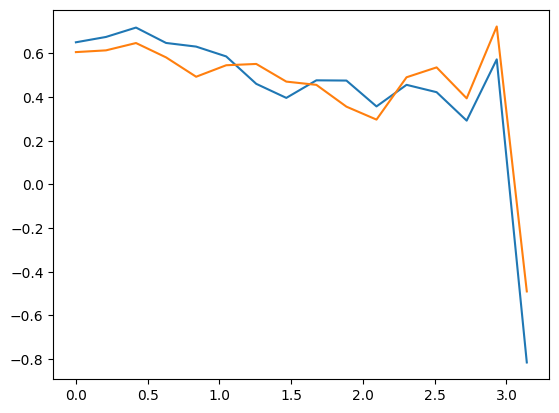

In [40]:
pl.figure()
pl.plot(theta, Qk_truth, label='Truth')
pl.plot(theta, Qk_mock, label='AR-NPE')
# pl.xscale('log')
# pl.yscale('log')

